# Raster processing with shapefile
This notebook has 3 tasks: 
1. Generate a square bounding box based on the extent of our shapefile. 
2. Clip our raster file using the square bounding box. In this way, we can get the raster file covering the whole RoI but with the size as small as possible. 
3. Create a raster mask layer based on our shapefile. 

## 1 - Generate the square bounding box based on the extent of our shapefile

In [8]:
import os
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
# 16 Oct 2023: gdal must be imported first, and then rasterio can be imported
from osgeo import gdal
import rasterio as rio

In [3]:
# Set some directories. Here we use absolute directories. 
cwd = 'c:\\Users\\m1865\\Desktop\\Ticino'
cwd_Field = cwd + '\\FieldData'
cwd_Field_Correct = cwd_Field + '\\ShapefileCorretti'
cwd_ProcessedRaster = cwd + '\\ProcessedData'

In [4]:
# Read our corrected shapefile
field_ShpCorrect = gpd.read_file(cwd_Field_Correct)

In [5]:
# Get the bounds of the shapefile [minx miny maxx maxy]
field_ShpCorrect_Box = field_ShpCorrect.total_bounds

In [6]:
# Since all the rasters are square, we need to make our bounding box a square as well. Thanks to the UTM projection, the distances can be measured directly. 
field_distance_x = field_ShpCorrect_Box[2] - field_ShpCorrect_Box[0]
field_distance_y = field_ShpCorrect_Box[3] - field_ShpCorrect_Box[1]
side_length = 0
print("The horizontal distance is " + str(field_distance_x))
print("The vertical distance is " + str(field_distance_y))
if (field_distance_x > field_distance_y):
    print("The side length of the raster should be the horizontal distance, " + str(field_distance_x))
    side_length = field_distance_x
else:
    print("The side length of the raster should be the vertical distance, " + str(field_distance_y))
    side_length = field_distance_y

The horizontal distance is 46114.47985919751
The vertical distance is 68814.38380348403
The side length of the raster should be the vertical distance, 68814.38380348403


<Axes: >

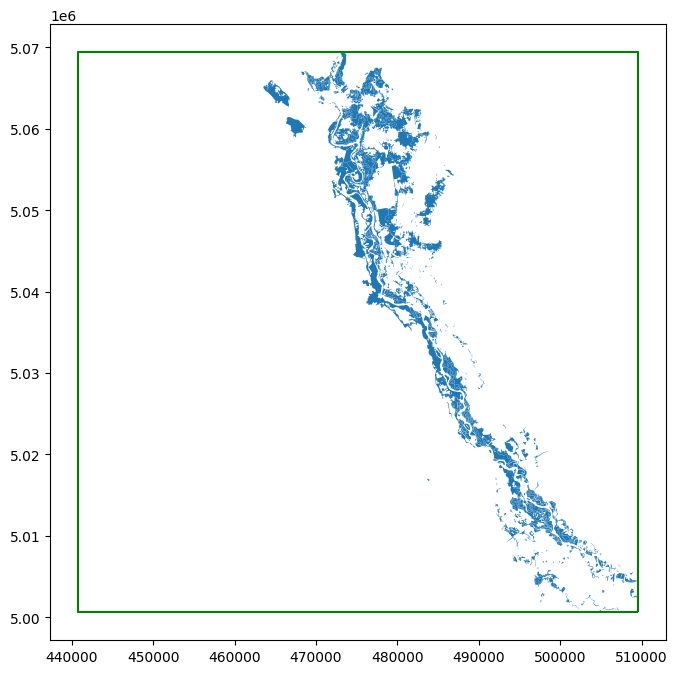

In [7]:
# Create this spatial square
field_Polygon = box(field_ShpCorrect_Box[2]-side_length,field_ShpCorrect_Box[1],field_ShpCorrect_Box[2],field_ShpCorrect_Box[3])
field_Square = gpd.GeoDataFrame(
    [1],
    geometry=[field_Polygon], # Don't forget the [] which makes our polygon into a list
    crs='EPSG:32632'
)
# Plot both the original shapefile and our new square bounding box
fig, ax1 = plt.subplots(1,figsize=(12,8))
field_ShpCorrect.plot(ax=ax1)
field_Square.boundary.plot(ax=ax1,color='green')

## 2 - Clip the rasters using the spatial square bounding box

In [14]:
# Read our raster files (Note: These raster files are produced in R studio and they are saved in seperate subfolders, and the names of the subfolders are identical to those of the processed raster files!)

# First, get the names of all the subfolders
raw_Raster_names = os.listdir(cwd_ProcessedRaster)
# Then read them and save each of the raster into a list
raw_Raster = []
for x in raw_Raster_names:
    temp_Raster = rio.open(cwd_ProcessedRaster + '\\' + x + '\\' + x)
    raw_Raster.append(temp_Raster)
raw_Raster

[<open DatasetReader name='c:/Users/m1865/Desktop/Ticino/ProcessedData/2022 06/2022 06' mode='r'>,
 <open DatasetReader name='c:/Users/m1865/Desktop/Ticino/ProcessedData/2022 09/2022 09' mode='r'>]

In [15]:
# There are some tags exclusive to ENVI header files, but "rasterio" fails to embed them. Thus we need to extract them and later create the correct ENVI header file by ourselves. 
# Since all the raster files have the same info regarding band names, wavelength and wavelength units, here we extract them from the first raster. 
str_ENVI_hdr_band_names = 'band_names= ' + raw_Raster[0].tags(ns='ENVI')['band_names']
str_ENVI_hdr_wavelength = 'wavelength= ' + raw_Raster[0].tags(ns='ENVI')['wavelength']
str_ENVI_hdr_wavelength_units = 'wavelength_units= ' + raw_Raster[0].tags(ns='ENVI')['wavelength_units']

In [18]:
# Clip the rasters and save them to local storage! 
import rasterio.mask
count = 0
for raster in raw_Raster: 
    out_image, out_transform = rasterio.mask.mask(raster,field_Square.geometry,crop=True)
    out_meta = raster.meta
    out_meta.update({"driver": 'ENVI',
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,                    
                    })
    with rasterio.open(cwd_ProcessedRaster + '\\' + raw_Raster_names[count] + '\\' + raw_Raster_names[count] + 'Cropped', "w", **out_meta) as dest:
        dest.write(out_image)
    print(raw_Raster_names[count] + 'Cropped has been saved successfully! ')
    count = count + 1

2022 06Cropped has been saved successfully! 
2022 09Cropped has been saved successfully! 


In [19]:
# Call our custom function to modify the header file, converting it to ENVI header format
import rasterio2ENVIhdr
for x in raw_Raster_names: 
    rasterio2ENVIhdr.rasterio2ENVIhdr(cwd_ProcessedRaster + '\\' + x + '\\' + x + 'Cropped.hdr',str_ENVI_hdr_band_names,str_ENVI_hdr_wavelength,str_ENVI_hdr_wavelength_units)
    print(x + 'Cropped.hdr has been converted to ENVI header file!')
# Now we have our cropped raster files, ready to be used in R Studio! 

Lines after the row 14 will be deleted!
2022 06Cropped.hdr has been converted to ENVI header file!
Lines after the row 14 will be deleted!
2022 09Cropped.hdr has been converted to ENVI header file!


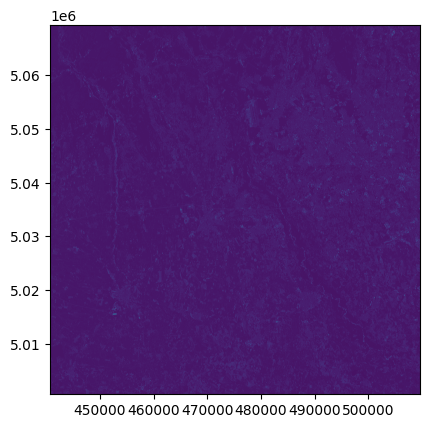

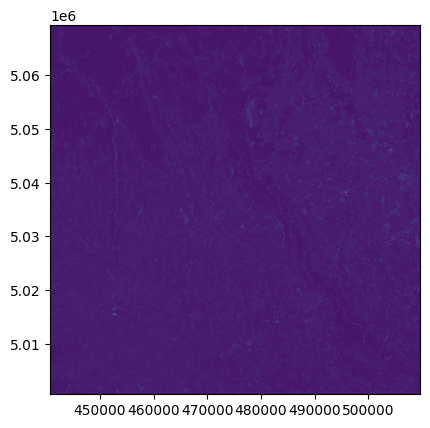

In [20]:
# Plot to see our cropped raster files? And meanwhile read them from local storage! 
from rasterio.plot import show
new_Raster = []
for x in raw_Raster_names:
    temp_Raster = rio.open(cwd_ProcessedRaster + '\\' + x + '\\' + x + 'Cropped')
    show(temp_Raster)
    new_Raster.append(temp_Raster)

## 3 - Rasterized the shapefile and export it as a mask raster layer
We actually don't need to perform the mask here, since later we will use the R package "biodivR", which requires both the original raster file and the mask raster layer as input, instead of using only the masked raster file as input. 

Rasterized successfully!
Rasterized successfully!


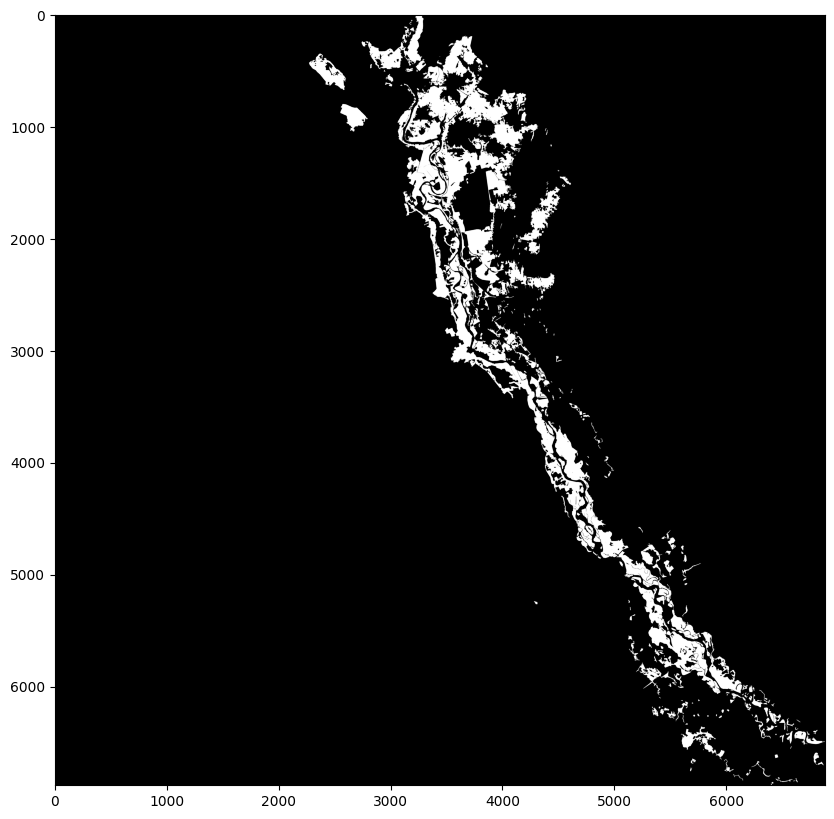

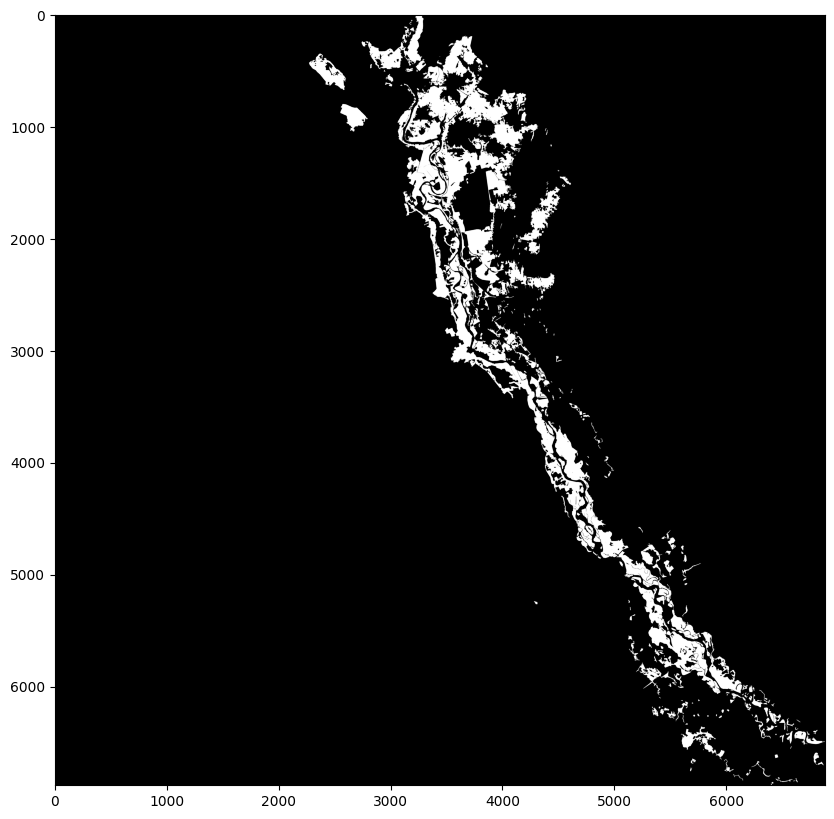

In [24]:
from rasterio import features
# Rasterize vector
rasterized = []
for raster in new_Raster:
    temp_Raster = features.rasterize(field_ShpCorrect.geometry,
                                    out_shape = raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = raster.transform, # "new_Raster.transform" contains information of pixel size and affine? 
                                    all_touched = False,
                                    default_value = 1, # 
                                    dtype = None)
    rasterized.append(temp_Raster)
    print('Rasterized successfully!')
    # Plot rasterized shapefile, since it will be used as a mask, then we choose colormap "Greys_r"
    fig, ax = plt.subplots(1, figsize = (10, 10))
    show(temp_Raster, ax = ax, cmap='Greys_r')

In [26]:
# We have rasterized our shapefile to a raster file, but it still has 8 bands and only the first band contains information. 
rasterized_meta = out_meta
rasterized_meta.update(
    count = 1,
)
# Save the rasterized shapefile
count = 0
for raster in rasterized:
    with rasterio.open(cwd_ProcessedRaster + '\\' + raw_Raster_names[count] + '\\' + raw_Raster_names[count] + 'Mask', "w", **rasterized_meta) as dest:
        dest.write(raster,indexes=1)
    print(raw_Raster_names[count] + 'Mask has been saved successfully! ')
    count = count + 1

2022 06Mask has been saved successfully! 
2022 09Mask has been saved successfully! 


In [27]:
# Call our custom function to modify the header file, converting it to ENVI header format
for x in raw_Raster_names: 
    rasterio2ENVIhdr.rasterio2ENVIhdr(cwd_ProcessedRaster + '\\' + x + '\\' + x + 'Mask.hdr', str_ENVI_hdr_band_names, str_ENVI_hdr_wavelength, str_ENVI_hdr_wavelength_units, is_Mask=True)
    print(x + 'Mask.hdr has been converted to ENVI header file!')
# Now we have our mask files, ready to be used in R Studio! 

Lines after the row 14 will be deleted!
2022 06Mask.hdr has been converted to ENVI header file!
Lines after the row 14 will be deleted!
2022 09Mask.hdr has been converted to ENVI header file!
